In [6]:
# Generic imports
#%%
import os
import random
import shutil
import progress.bar
from   datetime import datetime
from scipy.stats import qmc
import pandas as pd
from matplotlib import pyplot as plt


import shapes
import meshes
import importlib

importlib.reload(shapes)
importlib.reload(meshes)

from shapes import *
from meshes import *

### ************************************************
### Generate full dataset
# Parameters
def generate_samples(numero_samples,n_base, latin_gen_bool):
    n_sampling_pts = 20
    mesh_domain    = False
    plot_pts       = True
    show_quadrants = True
    n_shapes       = numero_samples
    time           = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')
    dataset_dir    = 'dataset_'+time+'/'
    mesh_dir       = dataset_dir+'meshes/'
    img_dir        = dataset_dir+'images/'
    det_img_dir    = dataset_dir+'det_images/'
    bit_img_dir    = dataset_dir+'bit_images/'
    save_det_plot = False

    filename       = 'shape'
    magnify        = 1.0
    max_radius = (2)**0.5
    xmin           =-2.0
    xmax           = 2.0
    ymin           =-2.0
    ymax           = 2.0
    n_tri_max      = 5000
    n_pts = n_base

    ### generate latin hypercube points in the defined space
    equ_dim_lim = 1.5

    if latin_gen_bool != False:
        latin_gen = qmc.LatinHypercube(d=n_pts*2)
        latin_gen = latin_gen.random(n=n_shapes)
        latin_gen = equ_dim_lim * latin_gen

        latin_gend2 = qmc.LatinHypercube(d=n_pts*2)
        latin_gend2 = latin_gend2.random(n=n_shapes)
        latin_gend2 = latin_gend2 * 0.9
        radius_tot = latin_gend2.reshape(-1,n_shapes,n_pts)
        edgy_tot   = latin_gend2.reshape(-1,n_shapes,n_pts)
    else:
        latin_gen = False


    # Create directories if necessary
    if not os.path.exists(mesh_dir):
        os.makedirs(mesh_dir)
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)
    if not os.path.exists(det_img_dir):
        os.makedirs(det_img_dir)
    if not os.path.exists(bit_img_dir):
        os.makedirs(bit_img_dir)

    # Generate dataset
    bar = progress.bar.Bar('Generating shapes', max=n_shapes)
    df = pd.DataFrame(columns=['curve_points', 'area', 'perimeter','bitmap'])

    for i in range(0,n_shapes):
        generated = False
        while (not generated):
            if not latin_gen_bool:
                #n_pts  = random.randint(3, 7)
                radius = np.random.uniform(0.0, .9, size=n_pts)
                edgy   = np.random.uniform(0.0, .9, size=n_pts)
            else:
                radius = radius_tot[0,i,:]
                edgy   = radius_tot[1,i,:]

            shape  = Shape(filename+'_'+str(i),
                        None,
                        n_pts,
                        n_sampling_pts,
                        radius,
                        edgy,
                        save_det_plot = save_det_plot)
            
            shape.generate(magnify=1.0,
                        xmin=xmin,
                        xmax=xmax,
                        ymin=ymin,
                        ymax=ymax,
                        latin_gen = latin_gen)
            
            if save_det_plot:
                img  = filename+'_'+str(i)+"det_plot"+'.png'
                shutil.move(img,  det_img_dir)
            
            shape.generate_bitmap(bit_im=True)

            img  = filename+'_'+str(i)+"bit"+'.png'
            shutil.move(img,  bit_img_dir)


            new_rows = [{'curve_points': shape.curve_pts, 'area': shape.area, 'perimeter': shape.curve_length, "bitmap": shape.bitmap}]
            df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
            generated = True
            #meshed, n_tri = shape.mesh()
            """
            if (True):
                shape.generate_image(plot_pts=plot_pts,
                                    max_radius = max_radius,
                                    xmin=xmin,
                                    xmax=xmax,
                                    ymin=ymin,
                                    ymax=ymax,
                                    show_quadrants=True)
                img  = filename+'_'+str(i)+'.png'
                mesh = filename+'_'+str(i)+'.mesh'
                shutil.move(img,  img_dir)
                #shutil.move(mesh, mesh_dir)
                generated = True
            """
        bar.next()
    bit = df["bitmap"]
    curve = df["area"]
    # End bar
    bar.finish()
    return bit,df

    # %%


In [15]:
list_mse_mean = np.array([])
list_mse_var = np.array([])

bit, df1 = generate_samples(10,7, True)
stack1 = np.stack(bit.values)
mean1_img = np.mean(stack1, axis=0)
mse1 = np.mean((stack1 - mean1_img) ** 2, axis=(1, 2))
mean1 = np.mean(mse1)
var1 = np.var(mse1)
list_mse_mean = np.append(list_mse_mean, mean1)
list_mse_var = np.append(list_mse_var, var1)

/var/folders/9p/c80ms72x1zq5xk4ppbknqzlm0000gn/T/ipykernel_67825/2697588181.py:118: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)


<Figure size 640x480 with 0 Axes>

In [39]:
index = 3
points = df1["curve_points"][index][:,:2]
angles = np.arctan2(points[:, 1], points[:, 0])



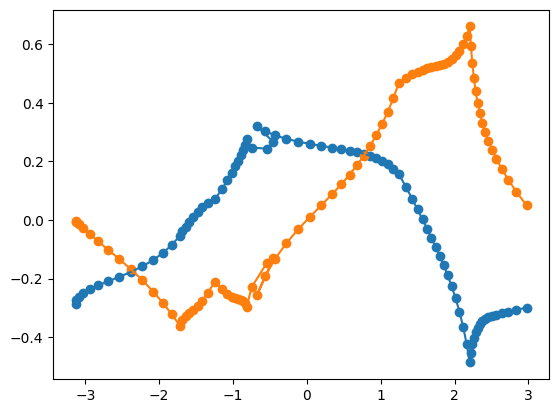

In [40]:
plt.plot(angles, points[:,0])
plt.scatter(angles, points[:,0])
plt.plot(angles, points[:,1])
plt.scatter(angles, points[:,1])


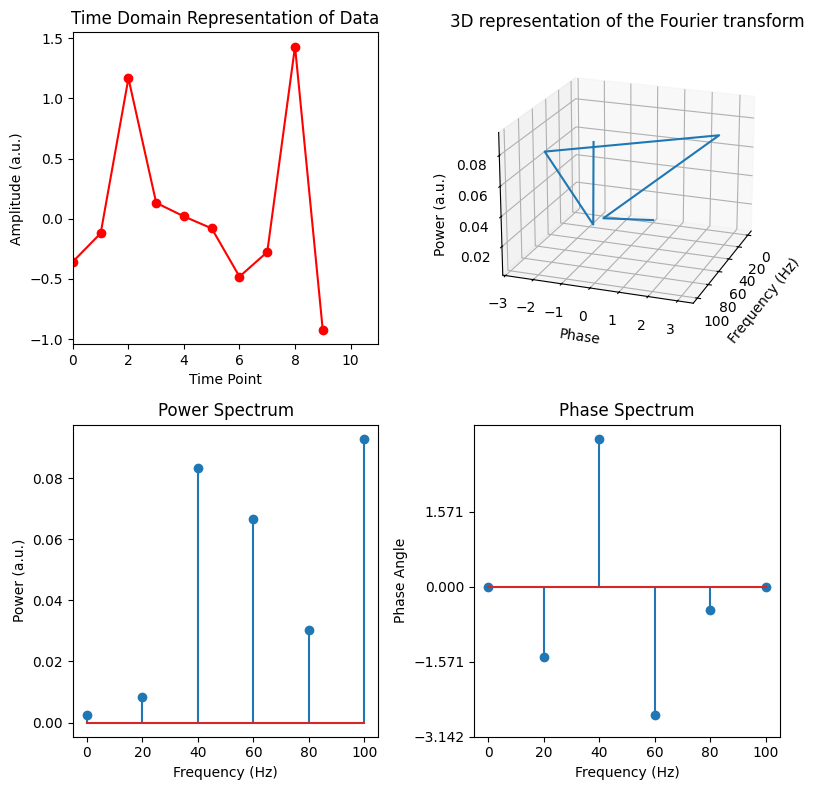

In [ ]:
# Figure 11.5
from mpl_toolkits.mplot3d import Axes3D
N = 10 #length of sequence
og_data = np.random.randn(N) #create random numbers, sampled from normal distribution
srate = 200 #sampling rate in Hz
nyquist = srate/2 #Nyquist frequency -- highest frequency you can measure the data

#initialize matrix for Fourier output

frequencies = np.linspace(0, nyquist, N//2+1)
time = np.arange(N)/float(N)

#Fourier transform is dot product between sine wave and data at each frequency
fourier = np.zeros(N)*1j #create complex matrix
for fi in range(N):
    sine_wave = np.exp(-1j *2 *np.pi*fi*time)
    fourier[fi] = np.sum(sine_wave*og_data)

fourier_og = fourier/float(N)

fig = plt.figure(figsize=(8,8))

plt.subplot(221)
plt.plot(og_data,"-ro",)
plt.xlim([0,N+1])
plt.ylabel('Amplitude (a.u.)')
plt.xlabel('Time Point')
plt.title("Time Domain Representation of Data")

ax = fig.add_subplot(222, projection='3d')
ax.plot(frequencies, np.angle(fourier_og[:N//2+1]), zs=np.absolute(fourier_og[:N//2+1])**2)
ax.view_init(20, 20)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Phase')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Power (a.u.)', rotation=90)
plt.title("3D representation of the Fourier transform")

plt.subplot(223)
plt.stem(frequencies, np.absolute(fourier_og[:N//2+1])**2)
plt.xlim([-5, 105])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (a.u.)")
plt.title("Power Spectrum")

plt.subplot(224)
plt.stem(frequencies, np.angle(fourier_og[:N//2+1]))
plt.xlim([-5, 105])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase Angle")
plt.yticks(np.arange(-np.pi, np.pi, np.pi/2.))

plt.title("Phase Spectrum")

plt.tight_layout()

In [48]:
time

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

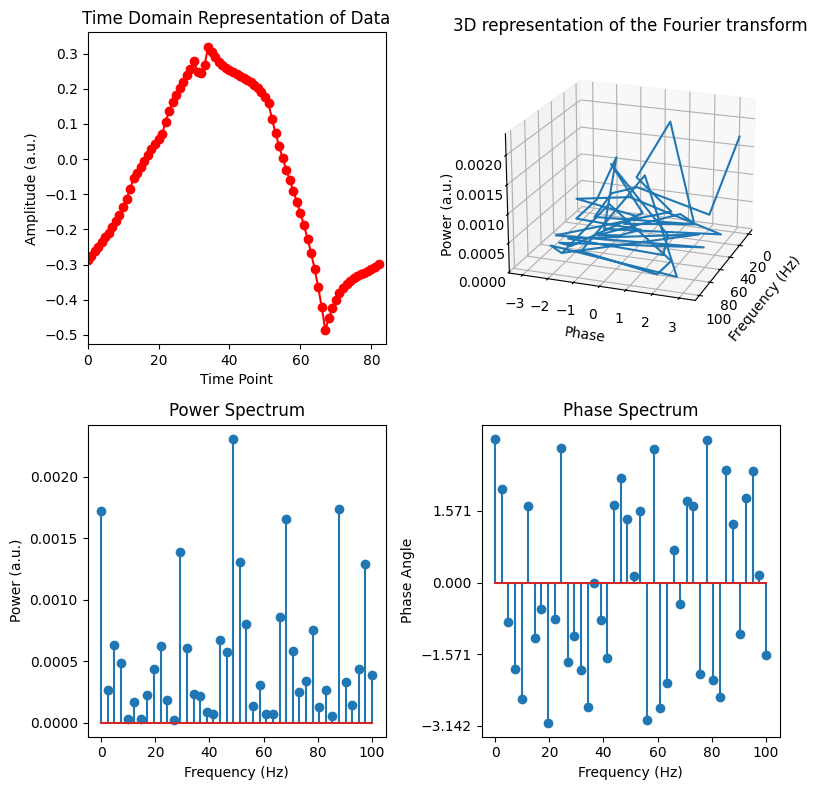

In [45]:
# Figure 11.5
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

N = angles.shape[0] #length of sequence
og_data =  points[:,0] #create random numbers, sampled from normal distribution
srate = 200 #sampling rate in Hz
nyquist = srate/2 #Nyquist frequency -- highest frequency you can measure the data

#initialize matrix for Fourier output

frequencies = np.linspace(0, nyquist, N//2+1)
time = angles

#Fourier transform is dot product between sine wave and data at each frequency
fourier = np.zeros(N)*1j #create complex matrix
for fi in range(N):
    sine_wave = np.exp(-1j *2 *np.pi*fi*time)
    fourier[fi] = np.sum(sine_wave*og_data)

fourier_og = fourier/float(N)

fig = plt.figure(figsize=(8,8))

plt.subplot(221)
plt.plot(og_data,"-ro",)
plt.xlim([0,N+1])
plt.ylabel('Amplitude (a.u.)')
plt.xlabel('Time Point')
plt.title("Time Domain Representation of Data")

ax = fig.add_subplot(222, projection='3d')
ax.plot(frequencies, np.angle(fourier_og[:N//2+1]), zs=np.absolute(fourier_og[:N//2+1])**2)
ax.view_init(20, 20)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Phase')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Power (a.u.)', rotation=90)
plt.title("3D representation of the Fourier transform")

plt.subplot(223)
plt.stem(frequencies, np.absolute(fourier_og[:N//2+1])**2)
plt.xlim([-5, 105])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (a.u.)")
plt.title("Power Spectrum")

plt.subplot(224)
plt.stem(frequencies, np.angle(fourier_og[:N//2+1]))
plt.xlim([-5, 105])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase Angle")
plt.yticks(np.arange(-np.pi, np.pi, np.pi/2.))

plt.title("Phase Spectrum")

plt.tight_layout()

In [42]:
fourier

array([-3.44435875+0.j        , -0.61614816+1.20808857j,
        1.33946652-1.60156602j, -0.56313753-1.74521856j,
       -0.35975188-0.23644732j, -0.10867518+1.06297544j,
        0.15321131-0.40102419j,  1.04129127-0.69802835j,
       -1.7261477 -0.13059265j,  1.45091505-1.47007393j,
       -1.10035515+0.22634336j, -0.06915385-0.39689381j,
        1.2182666 -2.84447726j, -0.69307836-1.92007029j,
       -1.15620342-0.52027094j,  1.21986089-0.01135274j,
        0.54159307-0.57036186j, -0.05462318-0.69040203j,
       -0.288923  +2.1360216j , -1.32017148+1.48953361j,
        0.72169997+3.9219602j ,  2.96828059+0.43151247j,
        0.01863062+2.35652444j, -0.94753695-0.12448042j,
       -1.4259195 +0.31617338j, -0.62055629-0.26196572j,
       -0.39570197-0.54615501j,  1.84138317+1.58267134j,
        3.0300986 -1.50041618j, -0.43881869+1.95547592j,
       -0.13093957+1.31183353j, -0.64486337-1.39134876j,
       -2.27575304+0.05463544j, -0.50831878-0.78675239j,
       -1.09125326-0.78834696j,

In [43]:
frequencies

array([  0.        ,   2.43902439,   4.87804878,   7.31707317,
         9.75609756,  12.19512195,  14.63414634,  17.07317073,
        19.51219512,  21.95121951,  24.3902439 ,  26.82926829,
        29.26829268,  31.70731707,  34.14634146,  36.58536585,
        39.02439024,  41.46341463,  43.90243902,  46.34146341,
        48.7804878 ,  51.2195122 ,  53.65853659,  56.09756098,
        58.53658537,  60.97560976,  63.41463415,  65.85365854,
        68.29268293,  70.73170732,  73.17073171,  75.6097561 ,
        78.04878049,  80.48780488,  82.92682927,  85.36585366,
        87.80487805,  90.24390244,  92.68292683,  95.12195122,
        97.56097561, 100.        ])

In [46]:
time


array([-3.12891822, -3.12234694, -3.08929163, -3.02876258, -2.94052276,
       -2.82596577, -2.6891884 , -2.53743445, -2.38000323, -2.22578755,
       -2.08098542, -1.94834852, -1.82786412, -1.71792537, -1.68441131,
       -1.64104621, -1.59075405, -1.53587649, -1.47730319, -1.41370117,
       -1.34023138, -1.2449771 , -1.14672245, -1.07602211, -1.01943612,
       -0.97107335, -0.92844237, -0.89089185, -0.85887011, -0.83341076,
       -0.81564458, -0.74617478, -0.54509954, -0.45539772, -0.67699822,
       -0.56308133, -0.42941183, -0.27889312, -0.11816116,  0.04368413,
        0.19799661,  0.33920508,  0.46551809,  0.57797632,  0.6790456 ,
        0.77152525,  0.85792149,  0.94016259,  1.01951444,  1.09660908,
        1.17154265,  1.24401802,  1.34090177,  1.42531535,  1.49980107,
        1.56678866,  1.62843108,  1.68654235,  1.74257204,  1.79758575,
        1.85224505,  1.90679555,  1.96108033,  2.01459506,  2.0665903 ,
        2.11620906,  2.16263179,  2.2051967 ,  2.22168848,  2.24